# 1. Import des bibliothèques et modules utiles

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import pandas as pd #Pour la manipulation des DataFrames
import numpy as np #Pour les calcul et conversions de type
import re #Module Regex. Pour chercher, nettoyer ou remplacer du texte dans les tweets
from tqdm import tqdm #Pour afficher une barre de progression lors d’une boucle longue
import matplotlib.pyplot as plt #Pour les graphiques
from transformers import pipeline #Bibliothèque de Hugging Face pour le NLP RoBERTa. Permet d'analyser les sentiments dirrects
import torch #Pour la gestion des tenseurs rapidement
from pathlib import Path
from collections import Counter
import sys
import os

DIR = Path("/content/drive/MyDrive/Colab Notebooks")
sys.path.insert(0,str(DIR / "src"))

from utils_text import fix_mojibake, clean_text, is_retweet_from_text
from sentiment_model import *
from sentiment_analysis import *
from visualization import *
from geography_analysis import *
from data_loader import *
from polytical_visualizer import *
from polytical_labeler import *
from world_map import *

# Initialisations (constantes, chemins)
A modifier selon ses ressources!

In [41]:
#Echantillonnage car l'analyse sur tout le jeu de donnée prend trop de temps
N_TWEETS = 5 # par candidat
TEXT_COLUMN = "text_clean"
MODEL_ID = "cardiffnlp/twitter-roberta-base-sentiment-latest"
USER_ID_COLUMN = "user_id"
N_device=-1  #Pour utiliser le CPU. Changer par 0 si vous voulez utiliser le GPU
RAW_DIR = Path(DIR/"data/raw")
INT_DIR = Path(DIR/"data/clean")
INT_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR = Path(DIR/"outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
SEN_DIR = Path(DIR/"data/analysed")
SEN_DIR.mkdir(parents=True, exist_ok=True)
GEO_DIR = Path(DIR/"data/geo")
GEO_DIR.mkdir(parents=True, exist_ok=True)

#2. Nettoyage des données

 Fonction de lecture robuste

In [26]:
def read_tweets_csv(path: Path) -> pd.DataFrame:
    date_cols = ['created_at', 'user_join_date', 'collected_at']

    # Lire TOUT comme texte d'abord
    try:
        df = pd.read_csv(
            path,
            dtype=str,                # tout en texte
            keep_default_na=False,
            na_values=['', 'NA', 'NaN'],
            engine="python",
            on_bad_lines="skip"
        )
    except UnicodeDecodeError:
        df = pd.read_csv(
            path,
            dtype=str,
            encoding='latin-1',
            keep_default_na=False,
            na_values=['', 'NA', 'NaN'],
            engine="python",
            on_bad_lines="skip"
        )

    # Convertir les numériques APRÈS lecture
    numeric_cols = ['likes', 'retweet_count', 'user_followers_count', 'lat', 'long']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Convertir les dates
    for c in date_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce', utc=True)

    return df

Fonction de nettoyage pour un dataset

In [27]:
# Fonction qui lit un CSV de tweets, nettoie les données et sauvegarde un fichier sans retweets
def clean_single_candidate(path_in: Path, path_out: Path, target_label: str):


    #Lecture brute
    df = read_tweets_csv(path_in)

    #Colonnes attendues en ordre
    expected_cols = ["created_at","tweet_id","tweet","likes","retweet_count","source", "user_id","user_name","user_screen_name","user_description","user_join_date",
                     "user_followers_count","user_location","lat","long","city","country","continent","state","state_code","collected_at"]
    for c in expected_cols:
        if c not in df.columns:
            df[c] = pd.NA
    df = df[expected_cols]

    #Ajouter du label candidat
    df["target"] = target_label   # "Trump" ou "Biden"

    #Corrections d’encodage sur le texte
    text_cols = ["tweet","user_description","user_name","user_screen_name",
                 "user_location","city","country","state","continent","source"]
    for c in text_cols:
        if c in df.columns:
            df[c] = df[c].apply(fix_mojibake)
    for c in ["user_description", "user_location", "city", "country", "state"]:
        if c in df.columns:
            df[c] = df[c].apply(clean_text)  # ou une variante plus légère


    #Texte nettoyé + flag retweet
    df["text_clean"] = df["tweet"].apply(clean_text)
    df["is_retweet"] = df["tweet"].apply(is_retweet_from_text)
def clean_single_candidate(path_in: Path, path_out: Path, target_label: str):

    # Lecture brute
    df = read_tweets_csv(path_in)

    # Colonnes attendues en ordre
    expected_cols = ["created_at","tweet_id","tweet","likes","retweet_count","source",
                     "user_id","user_name","user_screen_name","user_description","user_join_date",
                     "user_followers_count","user_location","lat","long","city","country",
                     "continent","state","state_code","collected_at"]
    for c in expected_cols:
        if c not in df.columns:
            df[c] = pd.NA
    df = df[expected_cols]

    # Ajouter le label candidat
    df["target"] = target_label   # "Trump" ou "Biden"

    # Corrections d'encodage sur le texte
    text_cols = ["tweet","user_description","user_name","user_screen_name",
                 "user_location","city","country","state","continent","source"]
    for c in text_cols:
        if c in df.columns:
            df[c] = df[c].apply(fix_mojibake)

    for c in ["user_description", "user_location", "city", "country", "state"]:
        if c in df.columns:
            df[c] = df[c].apply(clean_text)

    # Sauvegarde du texte original avant de le nettoyer
    df["tweet_original"] = df["tweet"].copy()

    # Texte nettoyé + flag retweet
    df["text_clean"] = df["tweet"].apply(clean_text)
    df["is_retweet"] = df["tweet"].apply(is_retweet_from_text)

    # Remplacer le texte brut par le texte propre
    df["tweet"] = df["text_clean"]

    # Tri, suppression des doublons
    df = df.sort_values("created_at").drop_duplicates(subset=["tweet_id"])

    # Supprimer les retweets
    df = df[~df["is_retweet"]].copy()

    # Filtrer user_name et user_location
    df = df.dropna(subset=["user_name", "user_location"])
    df = df[(df["user_name"] != "") & (df["user_location"] != "")]

    df_clean = df.copy()

    # Sauvegarde
    df_clean.to_csv(path_out,
                   index=False,
                   encoding="utf-8-sig",
                   sep=";")

    print(f"{target_label}: {len(df_clean)} tweets sans retweets sur {len(df)} total")
    return df_clean

Fonction de nettoyage appliquée à Trump et à Biden

In [28]:
# Trump
df_trump_clean = clean_single_candidate(
    path_in       = RAW_DIR / "hashtag_donaldtrump.csv",
    path_out  = INT_DIR / "trump_clean.csv",
    target_label  = "Trump",
)

# Biden
df_biden_clean = clean_single_candidate(
    path_in       = RAW_DIR / "hashtag_joebiden.csv",
    path_out  = INT_DIR / "biden_clean.csv",
    target_label  = "Biden",
)

KeyboardInterrupt: 

In [ ]:
# Aperçu rapide
print(df_trump_clean.head(2)[["tweet","text_clean","is_retweet"]])
print(df_biden_clean.head(2)[["tweet","text_clean","is_retweet"]])

# Vérifier qu'il n'y a plus de retweets dans les versions _nort
print("Trump is_retweet (nort) :")
print(df_trump_clean["is_retweet"].value_counts())

print("Biden is_retweet (nort) :")
print(df_biden_clean["is_retweet"].value_counts())

In [33]:
df = pd.read_csv(INT_DIR/"trump_clean.csv", sep=";")


# Aucune URL dans tweet
URL_RE = re.compile(r'https?://\S+|www\.\S+')
print("URLs dans tweet :",
      df["tweet"].str.contains(URL_RE, regex=True, na=False).sum())

# Pas de # dans tweet
print("# dans tweet :",
      df["tweet"].str.contains("#", na=False).sum())

# Tout en minuscules dans tweet
print("Majuscules dans tweet :",
      df["tweet"].str.contains(r"[A-Z]", na=False).sum())

# Ponctuation forte supprimée dans tweet
print("Ponctuation forte dans tweet :",
      df["tweet"].str.contains(r"[:!\?,\.']", na=False).sum())

# Doubles espaces dans tweet
print("Doubles espaces dans tweet :",
      df["tweet"].str.contains(r"\s{2,}", na=False).sum())

# user_name & user_location non nuls / non vides
print("user_name manquants :",
      df["user_name"].isna().sum(),
      "vides :",
      (df["user_name"] == "").sum())

print("user_location manquants :",
      df["user_location"].isna().sum(),
      "vides :",
      (df["user_location"] == "").sum())

KeyboardInterrupt: 

In [88]:
df_trump_raw = pd.read_csv(RAW_DIR / "hashtag_donaldtrump.csv", engine="python", on_bad_lines="skip")
df_biden_raw = pd.read_csv(RAW_DIR / "hashtag_joebiden.csv", engine="python", on_bad_lines="skip")

print("Trump brut :", len(df_trump_raw))
print("Biden brut :", len(df_biden_raw))
print("Total brut :", len(df_trump_raw) + len(df_biden_raw))

Trump brut : 971087
Biden brut : 777073
Total brut : 1748160


In [89]:
df_trump_clean = pd.read_csv(INT_DIR / "trump_clean.csv", sep=";")
df_biden_clean = pd.read_csv(INT_DIR / "biden_clean.csv", sep=";")

print("Trump nettoyé:", len(df_trump_clean))
print("Biden nettoyé:", len(df_biden_clean))
print("Total nettoyé :", len(df_trump_clean) + len(df_biden_clean))

/tmp/ipython-input-4099544610.py:1: DtypeWarning: Columns (6,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trump_clean = pd.read_csv(INT_DIR / "trump_clean.csv", sep=";")
/tmp/ipython-input-4099544610.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_biden_clean = pd.read_csv(INT_DIR / "biden_clean.csv", sep=";")


Trump nettoyé: 671104
Biden nettoyé: 538551
Total nettoyé : 1209655


/tmp/ipython-input-1702663612.py:6: DtypeWarning: Columns (6,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trump_clean = pd.read_csv(INT_DIR / "trump_clean.csv", sep=";")
/tmp/ipython-input-1702663612.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_biden_clean = pd.read_csv(INT_DIR / "biden_clean.csv", sep=";")


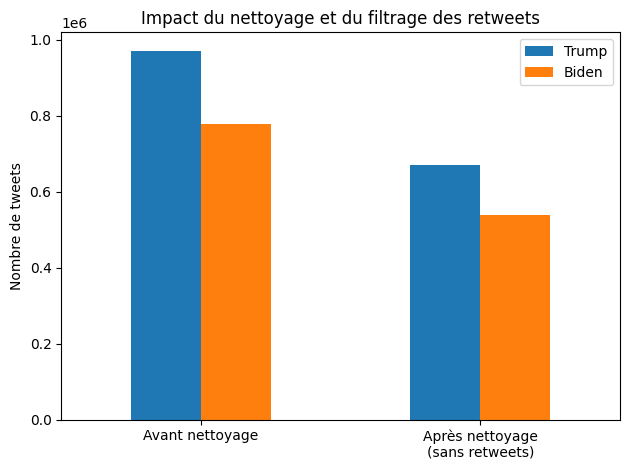

In [31]:

# Comptages bruts
df_trump_raw = pd.read_csv(RAW_DIR / "hashtag_donaldtrump.csv", engine="python", on_bad_lines="skip")
df_biden_raw = pd.read_csv(RAW_DIR / "hashtag_joebiden.csv", engine="python", on_bad_lines="skip")

# Comptages nettoyés (nort = sans retweets)
df_trump_clean = pd.read_csv(INT_DIR / "trump_clean.csv", sep=";")
df_biden_clean = pd.read_csv(INT_DIR / "biden_clean.csv", sep=";")

counts = pd.DataFrame({
    "Trump": [len(df_trump_raw), len(df_trump_clean)],
    "Biden": [len(df_biden_raw), len(df_biden_clean)],
}, index=["Avant nettoyage", "Après nettoyage\n(sans retweets)"])

counts.plot(kind="bar")
plt.ylabel("Nombre de tweets")
plt.title("Impact du nettoyage et du filtrage des retweets")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(OUT_DIR / "Impact_nettoyage_retweets.png", dpi=300)
plt.show()

# 3. Analyse des sentiments sur les données nettoyées

Préparation

In [26]:
#Identification des colonnes de texte. Certains CSV Kaggle ont plusieurs colonnes texte (tweet, text_clean, tweet_original). Cette fonction cherche automatiquement une colonne dont le nom contient "text"
def find_text_column(df):
    for col in df.columns:
        if "text" in col.lower():
            return col
    raise ValueError("Colonne texte introuvable")

trump_text_col = find_text_column(df_trump_clean)
biden_text_col = find_text_column(df_biden_clean)

#Vérification
print("Colonne Trump :", trump_text_col)
print("\n")
print("Colonne Biden :", biden_text_col)
print("\n")


Colonne Trump : text_clean


Colonne Biden : text_clean




Ajout de la colonne candidat au dataset

In [27]:
#On ajoute une colonne candidate pour identifier facilement à quel candidat appartient chaque tweet.
df_trump_clean["candidate"] = "Trump"
df_biden_clean["candidate"] = "Biden"

#Concatenation des deux DataFrames
df = pd.concat([df_trump_clean, df_biden_clean], ignore_index=True)
print("Dataset combiné :", df.shape)

df_sample = (
    df.groupby("candidate", group_keys=False)
      .apply(lambda x: x.sample(n=min(N_TWEETS, len(x)), random_state=42))
)

print("Dataset échantillonné :", df_sample.shape)

trump_sample = df_sample[df_sample['candidate'] == 'Trump']
biden_sample = df_sample[df_sample['candidate'] == 'Biden']


Dataset combiné : (1209655, 26)
Dataset échantillonné : (10, 26)


/tmp/ipython-input-2447206517.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(N_TWEETS, len(x)), random_state=42))


Préparation du modèle Hugging Face

In [28]:
#Chargement du modèle avec l'interface simplifiée de HF.
model = SentimentModel(MODEL_ID,N_device)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.pooler.dense.bias       | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 
roberta.pooler.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Analyse des sentiments

In [29]:
torch.set_grad_enabled(False) #Désactivation du gradient

def analyze_sentiment(texts, batch_size=64): #Fonction d'analyse de tweets par batch
    results = []
    # Vérifier que toutes les entrées sont des str
    texts = texts.fillna('').tolist()

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        preds = model.pipeline(batch)
        results.extend(preds)

    return results

print("Analyse des sentiments...")

#Implémentation sur les échantillons
trump_sentiments = analyze_sentiment(trump_sample[trump_text_col]) #Label du tweet et score du tweet entre 0 et 1
biden_sentiments = analyze_sentiment(biden_sample[biden_text_col])

#Ajout des résultats dans le DataFrame
trump_sample.loc[:, "sentiment"] = [s["label"] for s in trump_sentiments]
trump_sample.loc[:, "score"]     = [s["score"] for s in trump_sentiments]

biden_sample.loc[:, "sentiment"] = [s["label"] for s in biden_sentiments]
biden_sample.loc[:, "score"]     = [s["score"] for s in biden_sentiments]

Analyse des sentiments...



100%|██████████| 1/1 [00:05<00:00,  5.84s/it]

100%|██████████| 1/1 [00:03<00:00,  3.18s/it]
/tmp/ipython-input-1162111139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_sample.loc[:, "sentiment"] = [s["label"] for s in trump_sentiments]
/tmp/ipython-input-1162111139.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_sample.loc[:, "score"]     = [s["score"] for s in trump_sentiments]
/tmp/ipython-input-1162111139.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Résumé statistiques

In [30]:
summary_trump = trump_sample.groupby("sentiment").size().reset_index(name="count")
summary_biden = biden_sample.groupby("sentiment").size().reset_index(name="count")

summary_trump["candidate"] = "Trump"
summary_biden["candidate"] = "Biden"

# Combiner les deux
summary = pd.concat([summary_trump, summary_biden], ignore_index=True)
print(summary)


  sentiment  count candidate
0  negative      2     Trump
1   neutral      3     Trump
2  negative      1     Biden
3   neutral      3     Biden
4  positive      1     Biden


Sauvegarde dans un fichier CSV

In [31]:
# On combine les deux échantillons (Trump + Biden)
df_sample = pd.concat([trump_sample, biden_sample], ignore_index=True)
print(df_sample.head())
df_sample.to_csv(SEN_DIR/"tweets_with_sentiment.csv", index=False)
summary.to_csv(SEN_DIR/"sentiment_summary.csv", index=False)

print("\n Analyse terminée et sauvegardée")

                  created_at      tweet_id  \
0  2020-11-05 05:39:25+00:00  1.324225e+18   
1  2020-11-04 13:42:36+00:00  1.323984e+18   
2  2020-10-15 18:41:57+00:00  1.316812e+18   
3  2020-11-03 00:36:16+00:00  1.323424e+18   
4  2020-11-07 16:59:00+00:00  1.325121e+18   

                                               tweet  likes  retweet_count  \
0  la deutsche bank veut que trump lui rende 340 ...    1.0            0.0   
1  neither trump nor biden after the elections an...    0.0            0.0   
2  i ve been working to build progressive power i...    5.0            3.0   
3  what should conservatives libertarians do if j...    8.0            3.0   
4  trump du bist gefeuert you re fired usaelectio...    6.0            0.0   

                   source                user_id           user_name  \
0     Twitter for Android   956412153107533824.0       E. MERVA 🇹🇷 🌍   
1  App Political Hispanic   895688319358484480.0  Political Hispanic   
2     Twitter for Android            4

Visualisation

  candidate                                         text_clean sentiment  \
0     Trump  la deutsche bank veut que trump lui rende 340 ...   neutral   
1     Trump  neither trump nor biden after the elections an...  negative   
2     Trump  i ve been working to build progressive power i...   neutral   
3     Trump  what should conservatives libertarians do if j...   neutral   
4     Trump  trump du bist gefeuert you re fired usaelectio...  negative   
5     Biden      obese turtles or you people deserve for biden  negative   
6     Biden  abd de de biden ın başkan olacağını bilmek zor...   neutral   
7     Biden  sigue funcionando 不正選挙 elections2020 eleccione...   neutral   
8     Biden             tara reade disagrees biden broke metoo   neutral   
9     Biden  history made in usa 46th president biden and f...  positive   

      score  
0  0.774445  
1  0.750914  
2  0.606129  
3  0.893156  
4  0.780627  
5  0.776322  
6  0.809920  
7  0.854864  
8  0.689421  
9  0.676423  


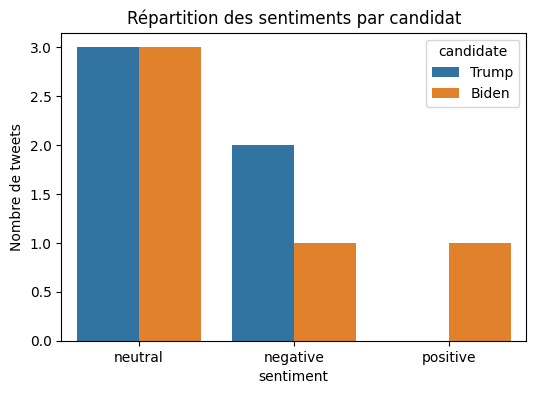

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
# Concaténer les DataFrames analysés
df_result = pd.concat([trump_sample, biden_sample], ignore_index=True)

# Vérifier que tout est correct
print(df_result[["candidate", trump_text_col, "sentiment", "score"]])

plt.figure(figsize=(6,4))
sns.countplot(data=df_result, x="sentiment", hue="candidate")
plt.title("Répartition des sentiments par candidat")
plt.ylabel("Nombre de tweets")
plt.savefig(OUT_DIR / "Répartition des sentiments par candidat.png", dpi=300)
plt.show()


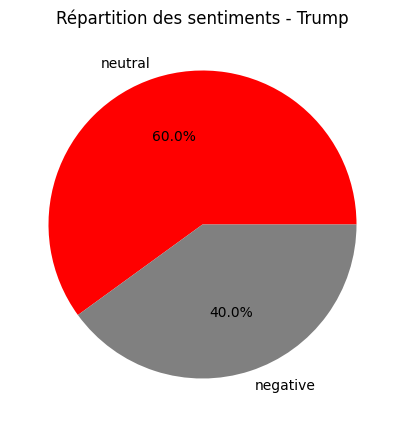

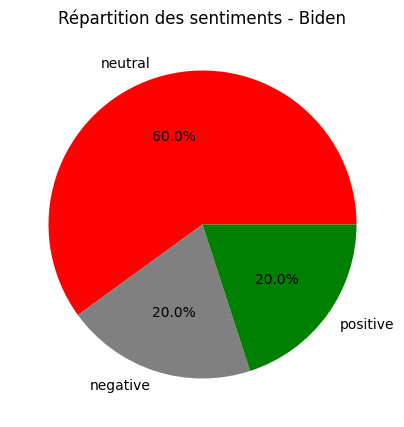

In [33]:
for candidate in ["Trump", "Biden"]:
    data = df_result[df_result["candidate"] == candidate]["sentiment"].value_counts()
    plt.figure(figsize=(5,5))
    plt.pie(data, labels=data.index, autopct="%1.1f%%", colors=["red","grey","green"])
    plt.title(f"Répartition des sentiments - {candidate}")
    plt.savefig(OUT_DIR / f"Répartition des sentiments - {candidate} (camembert).png", dpi=300)
    plt.show()


# 4. Analyse géographique

Création des analyzers avec les fichiers


In [34]:
print("Biden original:", df_biden_clean.shape)
print("Trump original:", df_trump_clean.shape)

#Création des analyzers avec fichiers
analyzer = GeographyAnalyzer()
biden = df_biden_clean
trump = df_trump_clean
geo_clean = analyzer.compare(biden, trump)

geo_clean.sort_values("Biden", ascending=False).head(20)


Biden original: (538551, 25)
Trump original: (671104, 25)


,user_location,Biden,Trump,diff,total
78626,united states,18099.0,21885.0,-3786.0,39984.0
79210,usa,7941.0,9976.0,-2035.0,17917.0
34268,india,6220.0,5376.0,844.0,11596.0
81775,washington dc,5174.0,7141.0,-1967.0,12315.0
43077,los angeles ca,4989.0,5113.0,-124.0,10102.0
11802,california usa,4729.0,5696.0,-967.0,10425.0
51509,new york ny,4218.0,3699.0,519.0,7917.0
25077,florida usa,3542.0,3707.0,-165.0,7249.0
51588,new york usa,3325.0,2749.0,576.0,6074.0
57327,paris,3301.0,4219.0,-918.0,7520.0


Filtrage pour ne garder que les États US


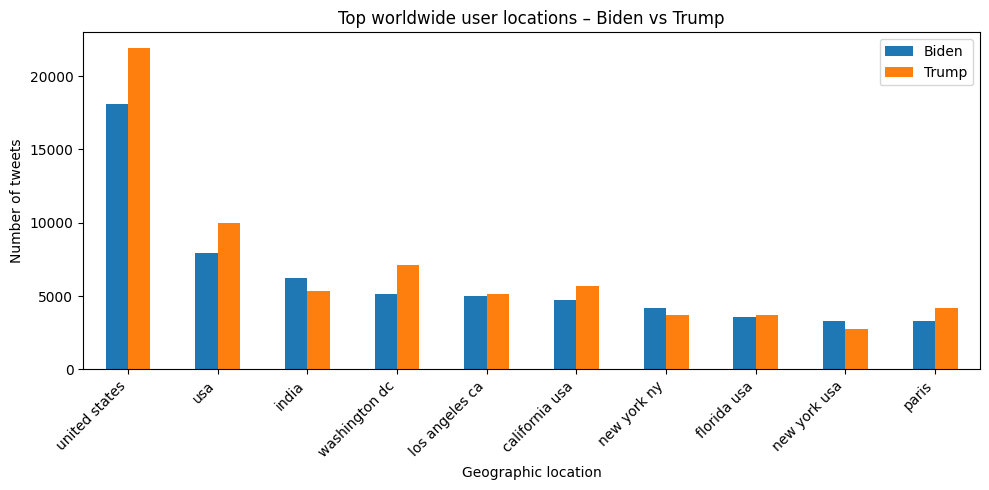

In [35]:
# user_location comme axe X
geo_clean_plot = geo_clean.set_index("user_location")

# Top 10 localisations
top10 = geo_clean_plot.sort_values("Biden", ascending=False).head(10)

# Graphe
top10[["Biden", "Trump"]].plot(
    kind="bar",
    figsize=(10,5),
    title="Top worldwide user locations – Biden vs Trump"
)

plt.ylabel("Number of tweets")
plt.xlabel("Geographic location")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig(OUT_DIR/"geo_barplot.png", bbox_inches="tight")
plt.show()

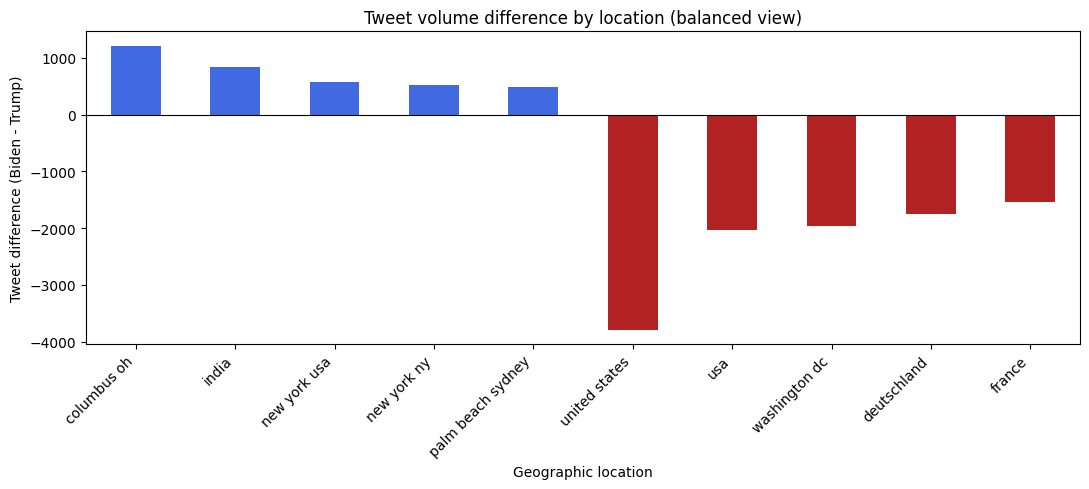

In [36]:
# Séparer Biden-dominant et Trump-dominant
biden_top = geo_clean[geo_clean["diff"] > 0].sort_values("diff", ascending=False).head(5)
trump_top = geo_clean[geo_clean["diff"] < 0].sort_values("diff").head(5)

# Fusionner
balanced = pd.concat([biden_top, trump_top])
balanced = balanced.set_index("user_location")

# Couleurs
colors = ["royalblue" if x > 0 else "firebrick" for x in balanced["diff"]]

# Plot
balanced["diff"].plot(
    kind="bar",
    figsize=(11,5),
    color=colors
)

plt.axhline(0, color="black", linewidth=0.8)
plt.title("Tweet volume difference by location (balanced view)")
plt.ylabel("Tweet difference (Biden - Trump)")
plt.xlabel("Geographic location")
plt.xticks(rotation=45, ha="right")
plt.savefig(OUT_DIR/"Tweet volume difference by location.png", bbox_inches="tight")
plt.tight_layout()
plt.show()

In [ ]:
import json
import requests
from pathlib import Path

# Charger directement depuis l'URL
print("📥 Chargement de countries.geojson depuis l'URL...")
url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
response = requests.get(url)
countries_geo = response.json()

# Chargement des tweets
analyzer = GeographyAnalyzer()
biden = analyzer.load(INT_DIR / "biden_clean.csv")
trump = analyzer.load(INT_DIR / "trump_clean.csv")

# Compare par user_location
geo_clean = analyzer.compare(biden, trump)

# Agrégation par pays (POO)
geo_country = analyzer.aggregate_by_country(geo_clean)

geo_country.head()

# dominance relative
geo_country["rel_diff"] = (geo_country["Biden"] - geo_country["Trump"]) / (geo_country["Biden"] + geo_country["Trump"])
geo_country["rel_diff"] = geo_country["rel_diff"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Harmonisation noms
name_fix = {"United States": "United States of America"}
geo_country["country_fixed"] = geo_country["country"].replace(name_fix)

value_by_country = dict(zip(geo_country["country_fixed"], geo_country["rel_diff"]))

# Build map
builder = WorldMapBuilder(levels=22)
m = builder.build(countries_geo, value_by_country)

out_path = OUT_DIR/ "world_dominance_22colors_OOP.html"
m.save(out_path)

print("✅ Saved:", os.path.abspath(out_path))
out_path

📥 Chargement de countries.geojson depuis l'URL...


# 5. Comparaison biden-trump

--- Comparaison BIDEN VS TRUMP ---
Analyse basée sur 5 utilisateurs Trump et 5 Biden
--- Analyse de sentiment ---
--- Visualisation ---


/content/drive/MyDrive/Colab Notebooks/src/visualization.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(pos, label=f"{label} positif", fill=True)


✅ Analyse Trump vs Biden terminée


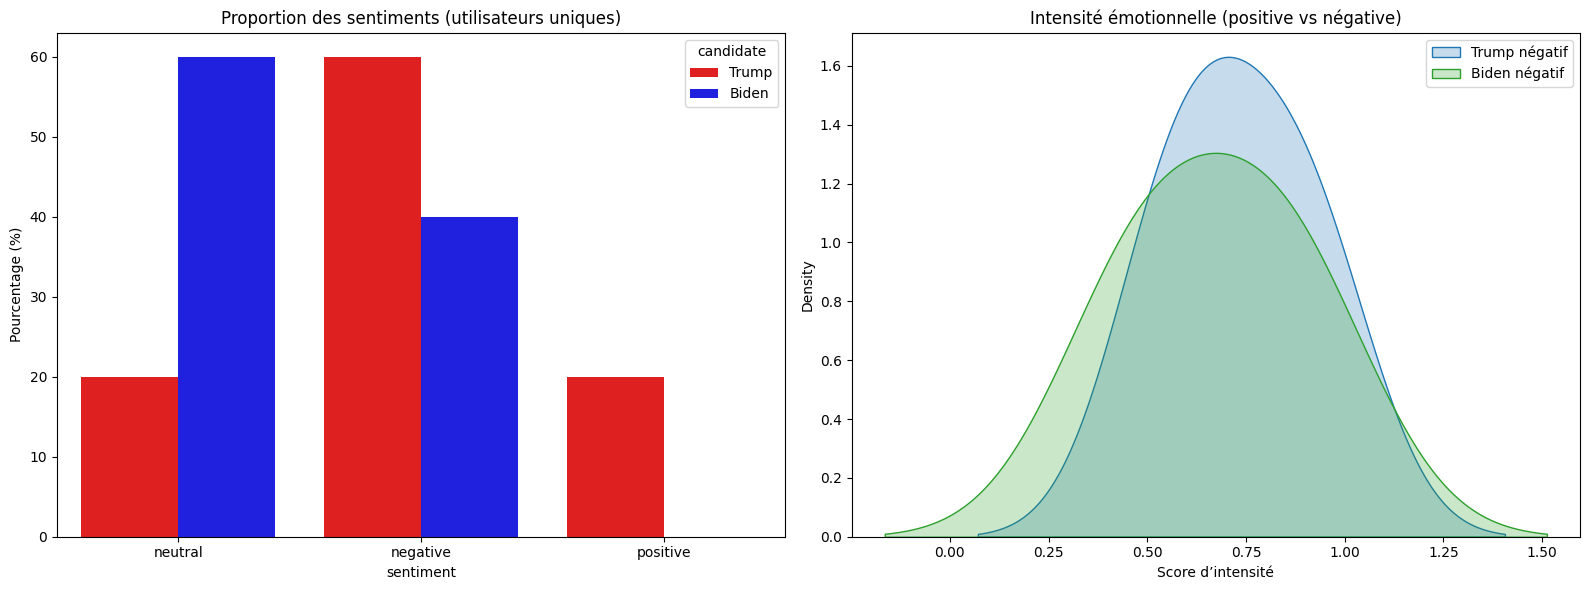

In [38]:
print("--- Comparaison BIDEN VS TRUMP ---")

loader_trump = DataLoader(INT_DIR / "trump_clean.csv", USER_ID_COLUMN)
loader_biden = DataLoader(INT_DIR / "biden_clean.csv", USER_ID_COLUMN)

df_trump = loader_trump.load_unique_users(N_TWEETS)
df_biden = loader_biden.load_unique_users(N_TWEETS)

print(f"Analyse basée sur {len(df_trump)} utilisateurs Trump et {len(df_biden)} Biden")

print("--- Analyse de sentiment ---")
analysis = SentimentAnalysis(model, TEXT_COLUMN)

df_trump = analysis.analyze_dataframe(df_trump)
df_biden = analysis.analyze_dataframe(df_biden)

print("--- Visualisation ---")
viz = Visualizer()
viz.plot_sentiment_proportions(
    df_trump,
    df_biden,
   OUT_DIR /"comparaison_utilisateurs_uniques.png"
)

print("✅ Analyse Trump vs Biden terminée")

# 6. Analyse des utilisateurs

Génération des graphiques pour Biden...
Aucune donnée pour le camp Biden
Génération des graphiques pour Trump...
Aucune donnée pour le camp Trump
Génération des graphiques pour les Neutres...
Aucune donnée pour le camp Neutral


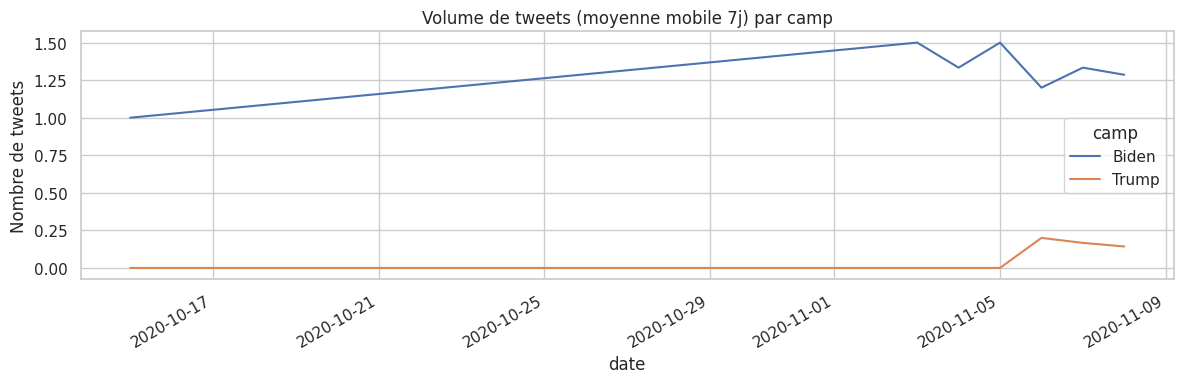

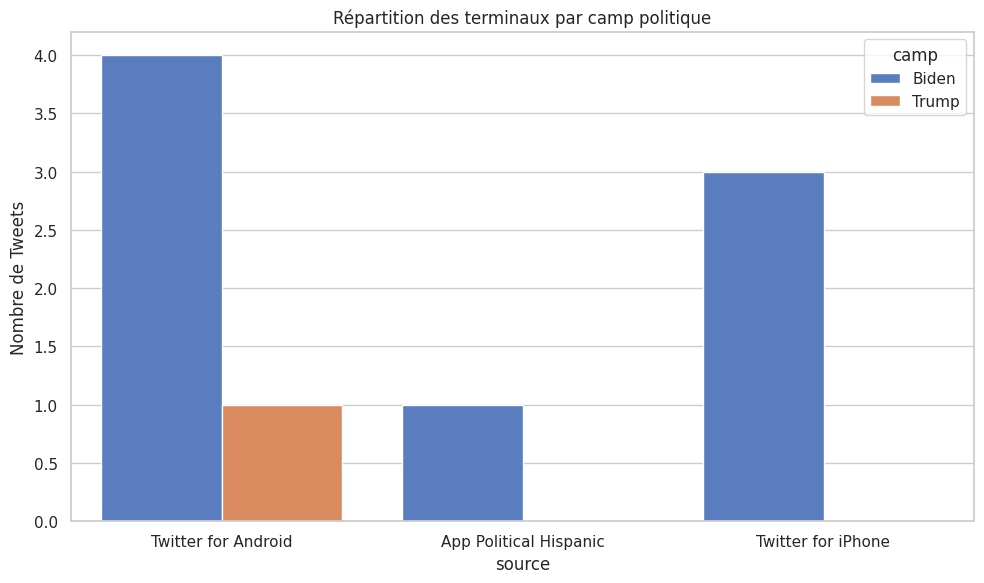

Seuil Biden: 0.0


In [57]:
# 1. Préparation
df = pd.read_csv(SEN_DIR/'tweets_with_sentiment.csv')

# 2. Traitement
engine = PoliticalLabeler(df)
engine.compute_alignment_scores().aggregate_users().define_camps()

# 3. Visualisation
viz = PoliticalVisualizer(engine)

print("Génération des graphiques pour Biden...")
viz.plot_top_influencers('Biden')

print("Génération des graphiques pour Trump...")
viz.plot_top_influencers('Trump')

print("Génération des graphiques pour les Neutres...")
viz.plot_top_influencers('Neutral')

# Les autres graphiques globaux
viz.plot_temporal_volume()
viz.plot_source_distribution()

# 4. Accès aux données propres
df_final = engine.user_study
print(f"Seuil Biden: {engine.thresholds['low']}")

Influenceurs Twitter par Camp Politique

Trace top influenceurs et top hashtags par camp

Top Mentions (@) par camp

Analyse temporelle